<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/IPCV_TASK_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

In [848]:
# Imported Libraries
import cv2
import os
from os import listdir
from google.colab.patches import cv2_imshow
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from scipy.signal import find_peaks
from collections import defaultdict
import itertools
import warnings
warnings.filterwarnings("ignore")


## Data Loading

In [849]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [850]:
def load_images_from_folder(folder_path):
  """
    returns a dictionary id_image: image
  """
  images = {}
  for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(image_path)
                id = int(re.findall(r'\d+', filename)[0])
                images[id] = img
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
  return images

In [851]:
models_folder = "dataset/models"
scenes_folder = "dataset/scenes"

In [852]:
scenes = load_images_from_folder(scenes_folder)
models = load_images_from_folder(models_folder)
print("The dataset contains ", len(scenes), "train images")
print("The dataset contains ", len(models), "query images")


The dataset contains  12 train images
The dataset contains  27 query images


In [853]:
scenes = {key: scenes[key] for key in sorted(scenes)}
models = {key: models[key] for key in sorted(models)}


## Image Overview

In [854]:
def get_overview(images, rows = 3, cols = 9, title = "scene"):
    """
    Plots a grid of images
    """
    w, h, dpi = 900, 500, 50
    fig, axs = plt.subplots(nrows = rows, ncols = cols, dpi = dpi, figsize = (w/dpi, h/dpi))
    for image_id, ax in zip(images, axs.ravel()):
      ax.imshow(cv2.cvtColor(images[image_id], cv2.COLOR_BGR2RGB))
      ax.set_title(title + str(image_id))
      ax.set_axis_off()
    fig.suptitle(f'{len(images)} images', fontsize = 20)
    fig.tight_layout(pad = 1)
    plt.show()

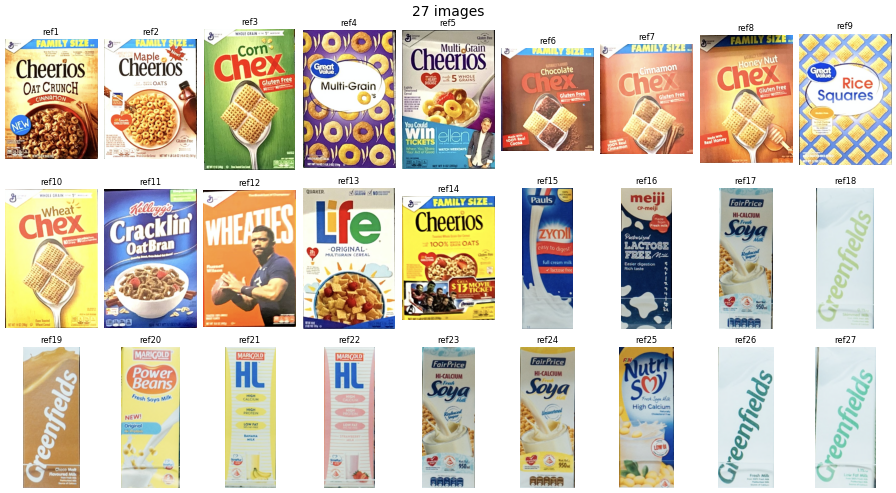

In [855]:
get_overview(models, title="ref")

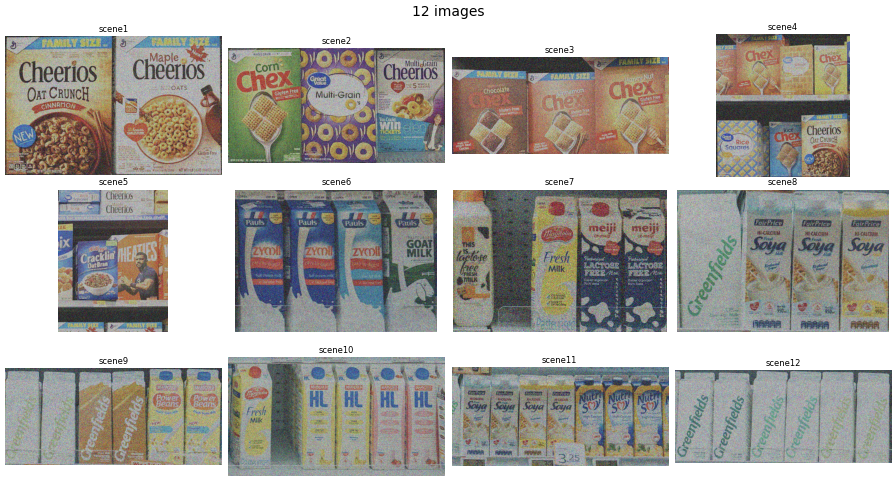

In [856]:
get_overview(scenes, rows=3, cols = 4)

## Image Filtering

We started by denoising the images, testing various methods to determine the most effective solution. We chose a combination that provided the best results with our: using median filters to eliminate salt-and-pepper noise and  bilateral filters to reduce overall noise while maintaining edge sharpness

In [918]:
def filter_image(img):
    '''
    Filters the image applying a concatenation of median
    filter and bilateral filter.

    '''
    denoised_img = cv2.medianBlur(img, 3)
    denoised_img = cv2.medianBlur(denoised_img, 3)
    denoised_img = cv2.medianBlur(denoised_img, 3)
    denoised_img = cv2.medianBlur(denoised_img, 3)
    denoised_img = cv2.medianBlur(denoised_img, 5)
    denoised_img = cv2.medianBlur(denoised_img, 5)
    denoised_img = cv2.bilateralFilter(denoised_img,  d=7, sigmaColor=60, sigmaSpace=85)
    denoised_img = cv2.bilateralFilter(denoised_img,  d=5, sigmaColor=40, sigmaSpace=85)
    denoised_img = cv2.bilateralFilter(denoised_img, d=1, sigmaColor=10, sigmaSpace=10)
    denoised_img = cv2.bilateralFilter(denoised_img, d=9, sigmaColor=20, sigmaSpace=80)
    denoised_img = cv2.bilateralFilter(denoised_img, d=11, sigmaColor=8, sigmaSpace=30)
    denoised_img = cv2.bilateralFilter(denoised_img, d=3, sigmaColor=10, sigmaSpace=50)
    denoised_img = cv2.bilateralFilter(denoised_img, d=5, sigmaColor=10, sigmaSpace=40)
    denoised_img = cv2.fastNlMeansDenoisingColored(denoised_img, None, 4, 7, 5, 15)
    return denoised_img

In [919]:

filtered_scenes = scenes.copy()
output_folder = '/content/dataset/scenes_filtered'
os.makedirs(output_folder, exist_ok=True)
for k, scene in filtered_scenes.items():
  filtered_scenes[k] = filter_image(scene)
  output_path = os.path.join(output_folder, "filtered_scene"+str(k)+".jpg")
  cv2.imwrite(output_path, filtered_scenes[k])


Images of the scene after denoising

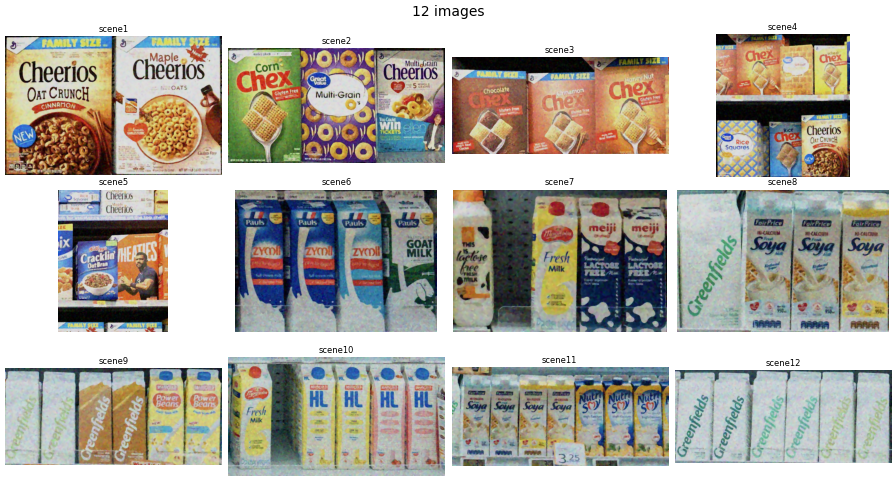

In [920]:
get_overview(filtered_scenes, rows=3, cols = 4)

## Track A - Single Instance Detection

Since Task A requires single instance detection, we decided to approach it using local invariant features with the **SIFT** descriptor. First, keypoints are detected and matched between the scene and model images. Next, **homography** is computed and used to identify the bounding boxes.

After detecting the bounding boxes, we implemented three additional filters to discard incorrect detections. These filters will also be useful for the second task. They focus on:

- **Shape regularity**: Ensures that the detected shape is consistent with the expected geometry of a box.

- **Color consistency**: Confirms that the color within the bounding box is uniform and matches the expected color profile.

- **Overlap**: Checks that the bounding boxes do not overlap beyond a specified threshold.

In [921]:
#selections of ids of scene and image of the first Task
models_idx = [i for i in range(1, 15)]
scenes_idx =   [i for i in range(1, 6)]

In [922]:
#filter dict by key
models_A = {k: models[k] for k in models_idx}
filtered_scenes_A = {k: filtered_scenes[k] for k in scenes_idx}

### Detection

#### Keypoints and Descriptor

In [923]:
def compute_SIFT_features(images):
    """
    Computes the SIFT features for each image in the dictionary
    """
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for image in images.values():
        #keypoints and descriptors
        kp, des = sift.detectAndCompute(image, None)
        keypoints.append(kp)
        descriptors.append(des)
    return keypoints, descriptors

In [924]:
kp_models, des_models = compute_SIFT_features(models_A)
kp_scenes, des_scenes = compute_SIFT_features(filtered_scenes_A)

#### Feature Matching

In [925]:
def get_matches(des_model, des_scene, max_distance_th = 0.65):
  '''
  returns the matches between the model and the scene
  '''
  FLANN_INDEX_KDTREE = 1
  # Defining parameters for algorithm
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  # Defining search params.
  search_params = dict(checks = 55)
  # Initializing matcher
  flann = cv2.FlannBasedMatcher(index_params, search_params)

  # Matching and finding the 2 closest elements for each query descriptor.
  good_matches = []
  matches = flann.knnMatch(des_scene, des_model, k=2)
  #discrimination of ambiguous matches
  for m,n in matches:
      if m.distance < max_distance_th*n.distance:
              good_matches.append(m)
  return good_matches

We create a matrix where each row represents a model Id, each column represents a scene Id, and each cell contains the matches between the model and the scene.

In [926]:
total_matches = {}
for i, des_m in enumerate(des_models):
    for j, des_s in enumerate(des_scenes):
          total_matches[(i + 1, j + 1)] = get_matches(des_m, des_s, 0.75)


#### Homographies

The details of the detections, including the model, scene, and homography data, have been encapsulated within the DetectedObject class.

In [927]:
class DetectedObject:

    def __init__(self, model_id, scene_id, matches, kp_models_pt, kp_scenes_pt, model):
        self.model_id = model_id
        self.scene_id = scene_id
        self.matches = matches
        self.src_pts = np.float32(kp_models_pt).reshape(-1,1,2)
        self.dst_pts = np.float32(kp_scenes_pt).reshape(-1,1,2)
        self.M, self.mask = cv2.findHomography(self.src_pts, self.dst_pts, cv2.RANSAC, 5.5)
        self.matchesMask = self.mask.ravel().tolist()
        self.h, self.w = model.shape[:2]
        self.pts = np.float32([[0,0],[0,self.h-1],[self.w-1,self.h-1],[self.w-1,0]]).reshape(-1,1,2)
        self.dst = cv2.perspectiveTransform(self.pts,self.M)
        self.centroid = np.mean(self.dst, axis=0, dtype=np.int32)[0]

    def project_in_scene(self):
        return self.dst

    def __str__(self):
        return f"Model {self.model_id} detected in scene {self.scene_id} with {len(self.matches)} matches"

    def get_measures(self):
        return self.centroid, self.w, self.h
    def get_num_matches(self):
        return len(self.matches)
    def set_color_similarity(self, value):
      self.color_similarity = value

    def get_color_similarity(self):
      return self.color_similarity

In [928]:
def get_kp_dict(keypoints):
  kp_dict = {
            "pt": np.asarray([kp.pt for kp in keypoints]),
            "angle": np.asarray([kp.angle for kp in keypoints]),
            "size": np.asarray([kp.size for kp in keypoints])
        }
  return kp_dict


#### Filters

The three before mentioned filters have been implemented according to the following approaches:
- **Shape**: verifies if the detected object can be a rectangle or square by approximating its contour to a polygon and checking if it has four vertices

- **Color Similarity**: In the RGB color space, colors are organized differently from human perception, making it insufficient to merely calculate the distance between RGB values to assess similarity. To align more closely with human perception, we should use the CIELAB color space. In this space, the Delta E (ΔE) metric can be employed to measure color differences more accurately, as it incorporates various thresholds to determine the perceptual similarity between colors.

- **Filters Overlap**: Calculates the Intersection Over Union (IoU) to determine if two bounding boxes overlap beyond a specified threshold. When applying this method, boxes are ordered by the number of matches. Consequently, if multiple detections are made at the same location, only the most reliable detection is kept.

In [929]:
from skimage.color import rgb2lab, deltaE_ciede2000
class Filter:
  def __init__(self):
    pass

  def check_shape(self, dst):
    '''
    checks if the object can be a rectangule/square
    '''
    dst = np.int32(dst)
    # Approximate the contour to a polygon
    epsilon = 0.04 * cv2.arcLength(dst, True)
    approx = cv2.approxPolyDP(dst, epsilon, True)

    # Check if the polygon has 4 vertices
    if len(approx) == 4:
            return True
    return False

  def get_color_similarity(self, im1,im2):
    if im1.shape[0] == 0 or im1.shape[1] == 0 or im2.shape[0] == 0 or im2.shape[1] == 0:
        return False
    img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2LAB)
    img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2LAB)
    # resize the img2
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    # get the delta E
    d = deltaE_ciede2000(img1, img2)

    return np.mean(d)
  def check_color_similarity(self, im1, im2, th = 25):
    '''
    checks if the color of the object is similar under a certain threshold
    '''
    return self.get_color_similarity(im1, im2) < th

  def filter_overlap(self, detections, threshold = 0.3):
    '''
    filters the detections that overlap with other detections
    '''
    filtered_detections = []
    for i, obj in enumerate(detections):
          dst = obj.project_in_scene()
          keep = True
          for j, obj2 in enumerate(detections):
              if i != j:
                  dst2 = obj2.project_in_scene()
                  iou = self.__calculate_iou(dst, dst2)
                  if iou >= threshold and len(obj.matches) <= len(obj2.matches):
                      keep = False
                      break

          if keep:
              filtered_detections.append(obj)

    return filtered_detections

  def __calculate_iou(self, det1, det2):
    '''
    calculates the intersection over union of two detections
    '''
    x1, y1, w1, h1 = cv2.boundingRect(det1)
    x2, y2, w2, h2 = cv2.boundingRect(det2)
    # Determine the coordinates of the intersection rectangle
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)
    # Compute the width and height of the intersection rectangle
    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - inter_y1)
    # Compute the area of the intersection rectangle
    inter_area = inter_w * inter_h
    # Compute the area of both rectangles
    area1 = w1 * h1
    area2 = w2 * h2
    # Compute the area of the union
    union_area = area1 + area2 - inter_area
    # Compute IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou



#### Object Detection Computation

In [930]:
def get_ROI(scene, corners):
    '''
    returns the region of interest of the detected object
    '''
    x, y, w, h = cv2.boundingRect(corners)
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    roi_cropped = scene[y:y+h, x:x+w]
    return roi_cropped

In [931]:
def order_per_matches(detections):
    return sorted(detections, key=lambda x: x.get_num_matches(), reverse=True)

In [932]:
f = Filter()
detections = {}
MIN_MATCH_COUNT = 15

for key, matches in total_matches.items():
    if len(matches) < MIN_MATCH_COUNT:  # if not enough matches have been detected
        continue
    model_id, scene_id = key
    kp_scene_A  = [kp_scenes[scene_id - 1][k] for k in [m.queryIdx for m in matches]]
    kp_model_A = [kp_models[model_id - 1][z] for z in [m.trainIdx for m in matches]]
    kp_scenes_dict  = get_kp_dict(kp_scene_A)
    kp_models_dict = get_kp_dict(kp_model_A)
    detected_object = DetectedObject(model_id, scene_id, matches, kp_models_dict["pt"], kp_scenes_dict["pt"], models[model_id])
    dst = detected_object.project_in_scene()
    # filtering
    if(f.check_shape(dst)):
        scene_object = get_ROI(filtered_scenes[scene_id],dst)
        if (f.check_color_similarity(scene_object, models[model_id])):
          detections[scene_id] = detections.get(scene_id, []) + [detected_object]


In [933]:
true_detections = {}
for i, d in detections.items():
  #it starts by prioritizing objects with higher match counts
    d = order_per_matches(d)
    true_detections[i] = f.filter_overlap(d,0.1)

### Results Visualization

In [934]:
def show_results(scene, detections):
  '''
  shows the detected objects in the scene
  '''
  window_size =  (350, 350)
  color = (0, 255, 0)
  font_scale = 2.0
  font_thickness = 6
  found = []
  for i, obj in enumerate(detections):
      dst = obj.project_in_scene()
      cv2.polylines(scene, [np.int32(dst)], True, color, 20, cv2.LINE_AA)
      dst = dst.reshape(4, 2)
      centroid, w, h = obj.get_measures()
      text = "ref " + str(obj.model_id)
      found.append({"id" : obj.model_id, "centroid" : centroid, "w" : w, "h" : h})
      text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
      text_origin = (centroid[0] - text_size[0] // 2, centroid[1] + text_size[1] // 2)


      cv2.putText(scene, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)
      # Resize the image and display it
      resized_image = cv2.resize(scene, window_size)
  cv2_imshow(resized_image)
  print_detections(found)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

def print_detections(found):
  '''
  prints info about the detected objects in the scene
  '''
  product_counts = Counter(item["id"] for item in found)
  for product_id, count in product_counts.items():
    instances = [obj for obj in found if obj["id"] == product_id]
    print(f"\n Product {product_id} - {count} instance found:")
    for idx, obj in enumerate(instances, 1):
      print(f"  Instance {idx} {{position: ({obj['centroid'][0]}, {obj['centroid'][1]}), width: {obj['w']}px, height: {obj['h']}px}}")
    print("")



Scene 1


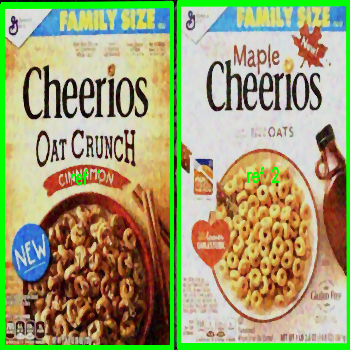


 Product 1 - 1 instance found:
  Instance 1 {position: (412, 539), width: 848px, height: 1108px}


 Product 2 - 1 instance found:
  Instance 1 {position: (1247, 533), width: 848px, height: 1108px}

Scene 2


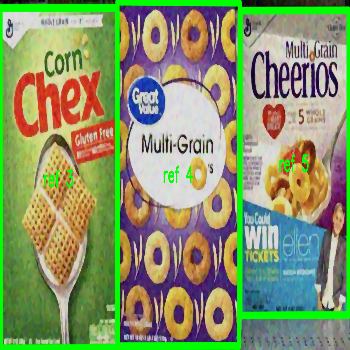


 Product 5 - 1 instance found:
  Instance 1 {position: (1527, 450), width: 792px, height: 1192px}


 Product 3 - 1 instance found:
  Instance 1 {position: (305, 492), width: 900px, height: 1402px}


 Product 4 - 1 instance found:
  Instance 1 {position: (926, 481), width: 894px, height: 1342px}

Scene 3


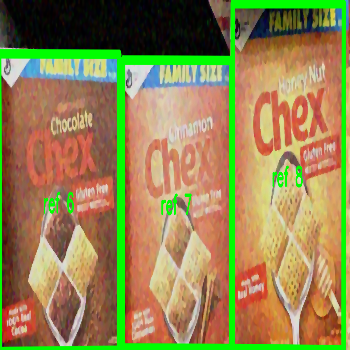


 Product 8 - 1 instance found:
  Instance 1 {position: (1446, 397), width: 736px, height: 1026px}


 Product 7 - 1 instance found:
  Instance 1 {position: (888, 460), width: 726px, height: 870px}


 Product 6 - 1 instance found:
  Instance 1 {position: (297, 456), width: 1164px, height: 1300px}

Scene 4


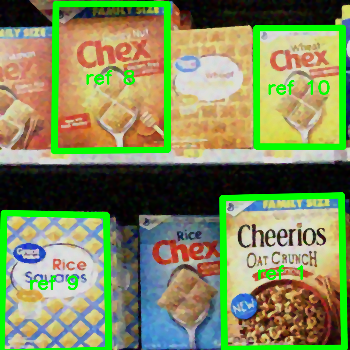


 Product 1 - 1 instance found:
  Instance 1 {position: (886, 913), width: 848px, height: 1108px}


 Product 8 - 1 instance found:
  Instance 1 {position: (348, 258), width: 736px, height: 1026px}


 Product 10 - 1 instance found:
  Instance 1 {position: (938, 292), width: 792px, height: 1190px}


 Product 9 - 1 instance found:
  Instance 1 {position: (172, 947), width: 698px, height: 992px}

Scene 5


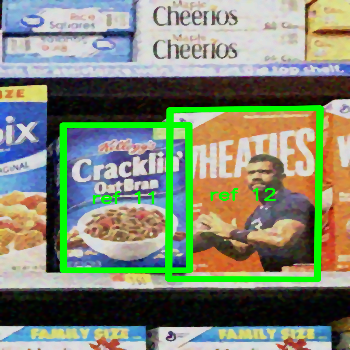


 Product 11 - 1 instance found:
  Instance 1 {position: (368, 751), width: 598px, height: 902px}


 Product 12 - 1 instance found:
  Instance 1 {position: (712, 738), width: 730px, height: 1086px}



In [935]:
for i in scenes_idx:
    print(f"Scene {i}")
    show_results(filtered_scenes[i], true_detections[i])


## Track B - Multiple Instances Detection

In multiple instance detection, our goal is to identify several occurrences of the same model. To achieve this, we applied the Star Model.
The obtained detection are then filtered using the previously mentioned filters (shape, color, overlap).



In [ ]:
filtered_scenes = {}

In [ ]:
files = os.listdir(output_folder)

for file in files:
    num = file.split('filtered_scene')[-1].split('.')[0]
    img = cv2.imread(os.path.join(output_folder, file))
    if img is None:
        continue
    cv2.imwrite(os.path.join(output_folder, file), img)
    filtered_scenes[int(num)] = img


    #os.rename(os.path.join(output_folder, file), os.path.join(output_folder, new_name))

In [ ]:
scenes_idx = [i for i in range(6, 13)]
models_idx =   [i for i in range(15, 28)]

In [ ]:
#models and scenes filtered by id
models_B = {k: models[k] for k in models_idx}
filtered_scenes_B = {k: filtered_scenes[k] for k in scenes_idx}

### Multiple Object Detections

We decided to detect multiple instances of the same product in an image using local invariant features combined with the Generalized Hough Transform (GHT).


#### Keypoints and Descriptors

In [ ]:
kp_models_B, des_models_B = compute_SIFT_features(models_B)
kp_scenes_B, des_scenes_B = compute_SIFT_features(filtered_scenes_B)

In [ ]:
class MulipleObjectDetector:
  def __init__(self, model_id, scene_id, models, scenes, kp_models_dict, kp_scenes_dict):
    self.model_id = model_id
    self.scene_id = scene_id
    self.models = models
    self.scenes = scenes
    self.kp_models_dict = kp_models_dict
    self.kp_scenes_dict = kp_scenes_dict
    self.set_parameters()

  def set_parameters(self, K=100, min_cluster_th = 0, reprojection_th = 6, peaks_params = {'height': 0.2, 'distance' : 1}):
    self.K = K
    self.min_cluster_th = min_cluster_th
    self.reprojection_th = reprojection_th
    img = self.scenes[self.scene_id]
    im2 = self.models[self.model_id]
    self.peaks_params = {'height': 0.3, 'distance' : (img.shape[0]*img.shape[1]) * 0.1 / self.K ** 2}


  def __get_voted_pos(self):
    #get barycenter and r vector
    bc, r_vectors = self.__compute_barycenter_and_rvector()

    angle = np.deg2rad(self.kp_scenes_dict["angle"] - self.kp_models_dict["angle"])
    scale_ratio = self.kp_scenes_dict["size"] / self.kp_models_dict["size"]
    r_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    r_matrix = np.transpose(r_matrix, (2, 0, 1))
    rot_r_vect = np.einsum('ijk,ik->ij', r_matrix, r_vectors).squeeze()
    scal_r_vect = rot_r_vect * scale_ratio[:, np.newaxis]
    voted_points = np.around(self.kp_scenes_dict["pt"] + scal_r_vect).astype(int)
    valid_points_pos = self.__get_mask_for_valid_votes(voted_points)
    return voted_points[valid_points_pos], valid_points_pos

 #Online Phase
  def __find_label(self, voted_points):

        scene_img = self.scenes[self.scene_id]
        #inizialization
        accumulator = np.zeros((scene_img.shape[1] // self.K, scene_img.shape[0] // self.K), dtype=np.float32)
        # Populate the accumulator based on vote positions
        for coordinate in voted_points:
            x_idx, y_idx = coordinate // self.K
            # Check if the coordinates are within the bounds of the accumulator
            if 0 <= x_idx < accumulator.shape[0] and 0 <= y_idx < accumulator.shape[1]:
                accumulator[x_idx, y_idx] += 1
        # Normalize the accumulator by its maximum value
        accumulator /= np.max(accumulator)
        # Flatten the accumulator and detect peaks
        flattened_acc = accumulator.ravel()
        peak_indices, _ = find_peaks(flattened_acc, **self.peaks_params)
        # Convert 1D peak indices to 2D coordinates and scale by grid dimension
        peak_coordinates = np.unravel_index(peak_indices, accumulator.shape)
        scaled_peak_positions = np.column_stack(peak_coordinates) * self.K

        # Get the number of votes and peaks
        total_votes = len(voted_points)
        total_peaks = len(scaled_peak_positions)
        predicted_labels = np.zeros(total_votes)

        # Return early if there are no peaks or only one peak
        if total_peaks < 2:
            return predicted_labels
        # Create a matrix to hold distance values
        distance_matrix = np.zeros((total_peaks, total_votes))
        # Calculate the distance from each vote position to each peak
        for peak_index, peak_position in enumerate(scaled_peak_positions):
            distance_matrix[peak_index] = np.linalg.norm(voted_points - peak_position, axis=1)
        # Assign each vote to the nearest peak
        predicted_labels = np.argmin(distance_matrix, axis=0)
        return predicted_labels

  def __find_homographies(self, predicted_labels, valid_points_pos):
    kp_valid_models = self.kp_models_dict["pt"][valid_points_pos]
    kp_valid_scenes = self.kp_scenes_dict["pt"][valid_points_pos]
    keypoints_used = []
    detected_objects = []
    f = Filter()
    scene_img = self.scenes[self.scene_id]
    model_img = self.models[self.model_id]

    for curr_label in np.unique(predicted_labels):
        mask = np.where(predicted_labels == curr_label)[0]
        if curr_label != -1 and len(kp_valid_models[mask]) >= self.min_cluster_th:
            kp_model_filtered = kp_valid_models[mask]
            kp_scene_filtered = kp_valid_scenes[mask]

        if len(kp_model_filtered) >= 4:
          M, mask = cv2.findHomography(kp_model_filtered, kp_scene_filtered, cv2.RANSAC, self.reprojection_th)
          if M is not None:

            detected_object = DetectedObject(self.model_id, self.scene_id, kp_model_filtered, kp_model_filtered, kp_scene_filtered, model_img)
            dst = detected_object.project_in_scene()
            #print("model", self.model_id, "scene", self.scene_id, "num_matches", len(kp_model_filtered))
            if(f.check_shape(dst)):
              scene_object = get_ROI(scene_img,dst)
              #print("\n shape")
              #print("model", self.model_id, "scene", self.scene_id, "num_matches", len(kp_model_filtered))

              if (f.check_color_similarity(scene_object, model_img, th = 18.5)):
                detected_object.set_color_similarity(f.get_color_similarity(scene_object, model_img))

                #print("color")
                #print("model", self.model_id, "scene", self.scene_id, "num_matches", len(kp_model_filtered))
                keypoints_used.append(len(kp_model_filtered))
                detected_objects.append(detected_object)
    return keypoints_used, detected_objects

  def __compute_barycenter_and_rvector(self):
    # get b
    kp = self.kp_models_dict["pt"]
    barycenter = np.mean(kp, axis=0)
    r = barycenter - kp
    return barycenter, r

  def __get_mask_for_valid_votes(self, voted_point):
      img =  self.scenes[self.scene_id]
      img_height, img_width = img.shape[:2]
      mask_x_within_bounds = (voted_point[:, 0] >= 0) & (voted_point[:, 0] < img_width)
      mask_y_within_bounds = (voted_point[:, 1] >= 0) & (voted_point[:, 1] < img_height)
      valid_mask = mask_x_within_bounds & mask_y_within_bounds
      return valid_mask




  def compute_homographies(self):
      voted_points, valid_points_pos = self.__get_voted_pos()
      predicted_labels = self.__find_label(voted_points)
      keypoints_used, detected_objects = self.__find_homographies(predicted_labels, valid_points_pos)
      return keypoints_used, detected_objects


#### Multiple Object Detection Computation

In [ ]:
#create a dict of arrays -> keys is the scene and the array contains the detection of each scene
dict_of_detections = defaultdict(list)
MIN_MATCH_COUNT = 4

for i, scene_idx in enumerate(scenes_idx): #for each scene
    for j, model_idx in enumerate(models_idx): #for each model

        matches = get_matches(des_models_B[j], des_scenes_B[i])
        if len(matches) < MIN_MATCH_COUNT: #if the number of matches is not enough
            continue
        kp_scene_B  = [kp_scenes_B[i][k] for k in [m.queryIdx for m in matches]]
        kp_model_B = [kp_models_B[j][z] for z in [m.trainIdx for m in matches]]

        kp_scenes_dict  = get_kp_dict(kp_scene_B)
        kp_models_dict = get_kp_dict(kp_model_B)
        detector = MulipleObjectDetector(model_idx, scene_idx, models_B, filtered_scenes_B, kp_models_dict, kp_scenes_dict)
        _, detections = detector.compute_homographies()
        dict_of_detections[i].append(detections)

#### Results Visualizations

In [ ]:
for k,v in dict_of_detections.items():
  dict_of_detections[k] = list(itertools.chain.from_iterable(v))


In [ ]:
for k in dict_of_detections.keys():
  dict_of_detections[k] = order_per_matches(dict_of_detections[k])


In [ ]:
for k,d in dict_of_detections.items():
   dict_of_detections[k] = f.filter_overlap(d, 0.35)


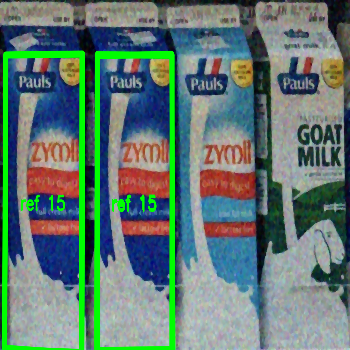


 Product 15 - 2 instance found:
  Instance 1 {position: (581, 619), width: 326px, height: 906px}
  Instance 2 {position: (187, 620), width: 326px, height: 906px}



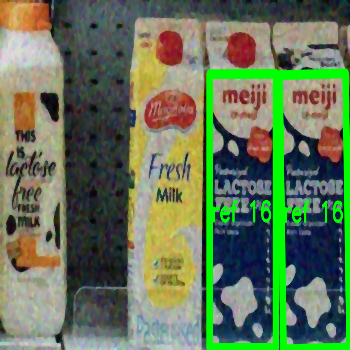


 Product 16 - 1 instance found:
  Instance 1 {position: (1029, 462), width: 436px, height: 1208px}



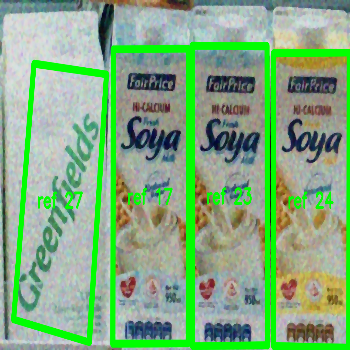


 Product 23 - 1 instance found:
  Instance 1 {position: (987, 566), width: 362px, height: 976px}


 Product 17 - 1 instance found:
  Instance 1 {position: (647, 568), width: 326px, height: 854px}


 Product 24 - 1 instance found:
  Instance 1 {position: (1337, 578), width: 368px, height: 956px}


 Product 27 - 1 instance found:
  Instance 1 {position: (260, 578), width: 460px, height: 1068px}



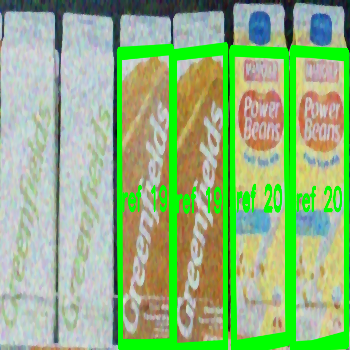


 Product 20 - 2 instance found:
  Instance 1 {position: (1104, 376), width: 456px, height: 1102px}
  Instance 2 {position: (1358, 375), width: 456px, height: 1102px}


 Product 19 - 2 instance found:
  Instance 1 {position: (850, 376), width: 444px, height: 1102px}
  Instance 2 {position: (619, 375), width: 444px, height: 1102px}



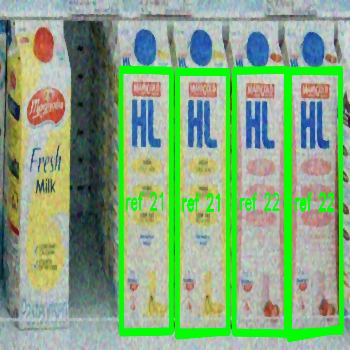


 Product 21 - 2 instance found:
  Instance 1 {position: (708, 535), width: 410px, height: 1156px}
  Instance 2 {position: (982, 537), width: 410px, height: 1156px}


 Product 22 - 2 instance found:
  Instance 1 {position: (1525, 538), width: 410px, height: 1156px}
  Instance 2 {position: (1261, 536), width: 410px, height: 1156px}



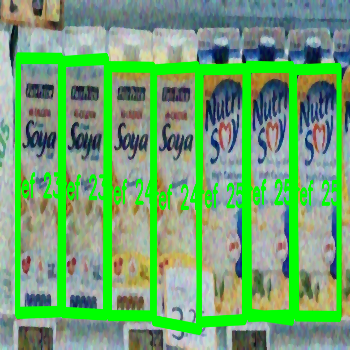


 Product 23 - 2 instance found:
  Instance 1 {position: (357, 359), width: 362px, height: 976px}
  Instance 2 {position: (165, 355), width: 362px, height: 976px}


 Product 25 - 1 instance found:
  Instance 1 {position: (1144, 369), width: 368px, height: 956px}



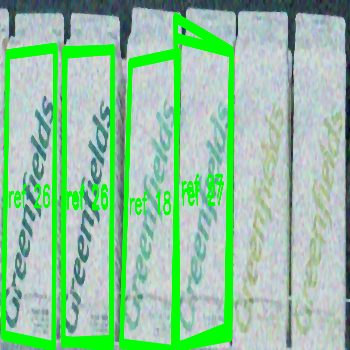


 Product 26 - 1 instance found:
  Instance 1 {position: (409, 397), width: 420px, height: 1068px}


 Product 27 - 1 instance found:
  Instance 1 {position: (941, 373), width: 460px, height: 1068px}



In [ ]:
for k,v in dict_of_detections.items():
    show_results(filtered_scenes_B[scenes_idx[k]], v)
cv2.destroyAllWindows()